Feature detection

Marius Dufraisse

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris
from skimage.transform import rotate, rescale, SimilarityTransform, resize, warp, AffineTransform, ProjectiveTransform
from skimage.color import rgb2lab
from skimage.measure import block_reduce
from scipy.spatial.distance import pdist, squareform, cdist
from skimage import measure

In [81]:
def point_map(points, color=(1,0,0), alpha=1.0):
    # Return an RGBA image where the points have alpha=1 and RGB = color
    disp = np.zeros((*points.shape, 4))
    for i in range(3):
        disp[:,:,i] = color[i]
    disp[:,:,3] = alpha * points
    return disp

In [4]:
img = plt.imread("val.png")
img = rgb2lab(img)[:,:,0]

imgr = resize(rotate(img, 90,resize=False),img.shape)

squares = np.zeros((256,256))
for (i,j) in np.ndindex(4,4):
    squares[64*i:64*i+32,64*j:64*j+32] = 1
    squares[64*i+32:64*i+64,64*j+32:64*j+64] = 1

## Harris detector ##

In [5]:
val_h = corner_harris(img)
squares_h = corner_harris(imgr)

In [6]:
def threshold(img, threshold, fixed = False):
    if not fixed:
        threshold = threshold * img.max()
    return img >= threshold

### Qualitative experiments ###

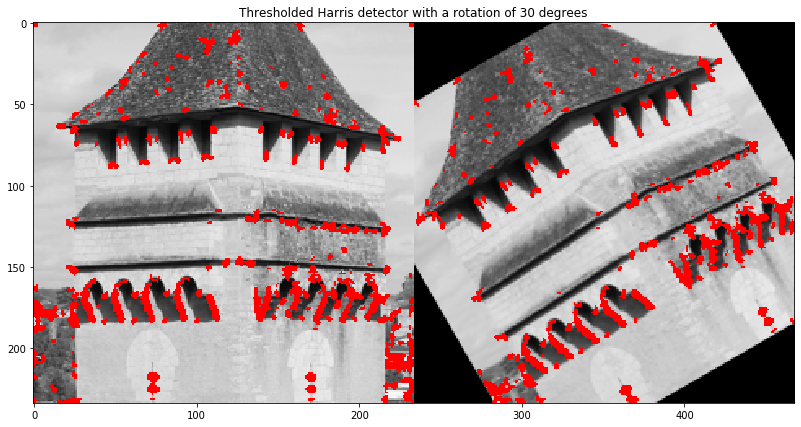

In [8]:
# Rotation
angle = 30
t = 0.01

imgb = rotate(img, angle)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))

plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((threshold(val_h,t,fixed=False),threshold(imgb_h,t,fixed=False)))))
plt.title("Thresholded Harris detector with a rotation of {} degrees".format(angle))
plt.show()


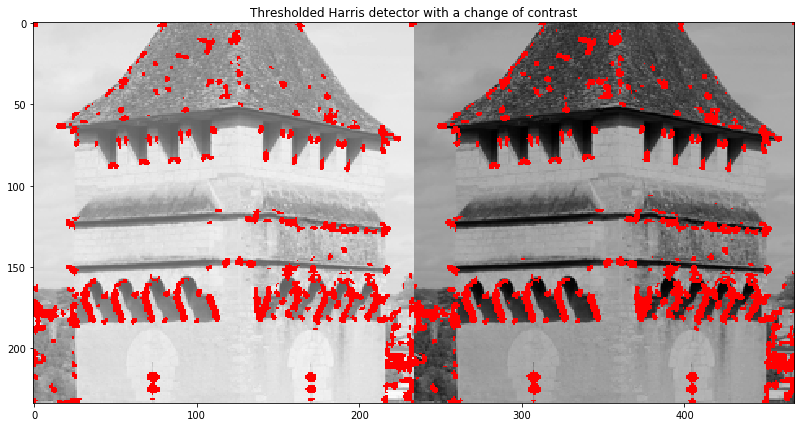

In [9]:
# Contrast change
t = 0.01

imgb = (img - img.mean()) * 1.25 + 20
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((threshold(val_h,t,fixed=False),threshold(imgb_h,t,fixed=False)))))
plt.title("Thresholded Harris detector with a change of contrast")
plt.show()


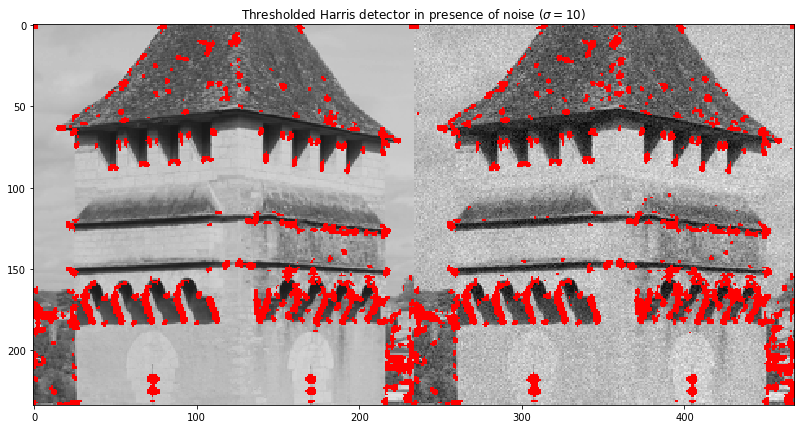

In [10]:
# Noise
sigma = 10

t = 0.01

imgb = img + 5 * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')


plt.imshow(point_map(np.hstack((threshold(val_h,t,fixed=False),threshold(imgb_h,t,fixed=False)))))
plt.title("Thresholded Harris detector in presence of noise ($\sigma ={}$)".format(sigma))
plt.show()


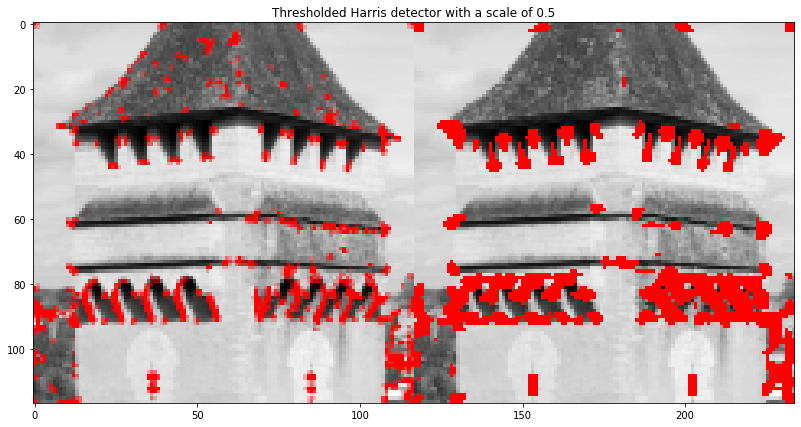

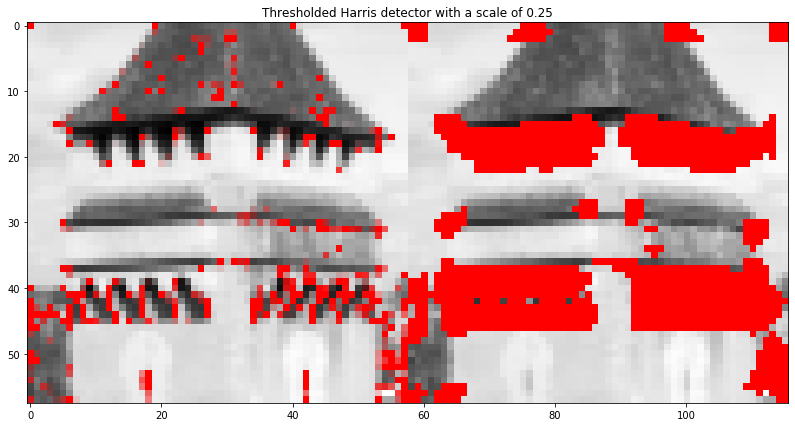

In [11]:
# Scale change
scale = [0.5,0.25]

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(threshold(val_h,0.01), imgb.shape, anti_aliasing=False)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((imgb,imgb)),cmap='gray')


    plt.imshow(point_map(np.hstack((scaled_a,threshold(imgb_h,0.01)))))
    plt.title("Thresholded Harris detector with a scale of {}".format(s))
    
    plt.show()


In [120]:
def median_pt_size(pts):
    # Computes the average size of connected components in pts
    labels, num = measure.label(pts, background=False, return_num=True)
    areas = np.zeros(num)
    for l in range(num):
        areas[l] = np.sum(labels == (l+1))
    return np.median(areas), num

def avrge_pt_size(pts):
    # Computes the average size of connected components in pts
    labels, num = measure.label(pts, background=False, return_num=True)
    areas = np.zeros(num)
    for l in range(num):
        areas[l] = np.sum(labels == (l+1))
    return np.mean(areas), num


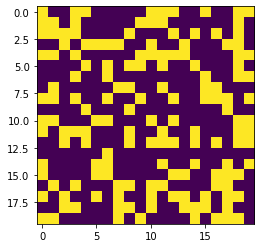

In [121]:
a = np.random.randn(20,20)>0.3
plt.imshow(a)
plt.show()


(10.2, 15)
(3.0, 15)


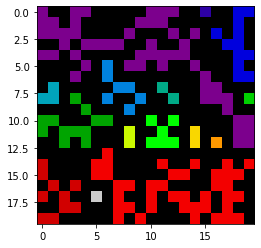

In [122]:
print(avrge_pt_size(a))
print(median_pt_size(a))
plt.imshow(measure.label(a,background=False), cmap='nipy_spectral')
plt.show()

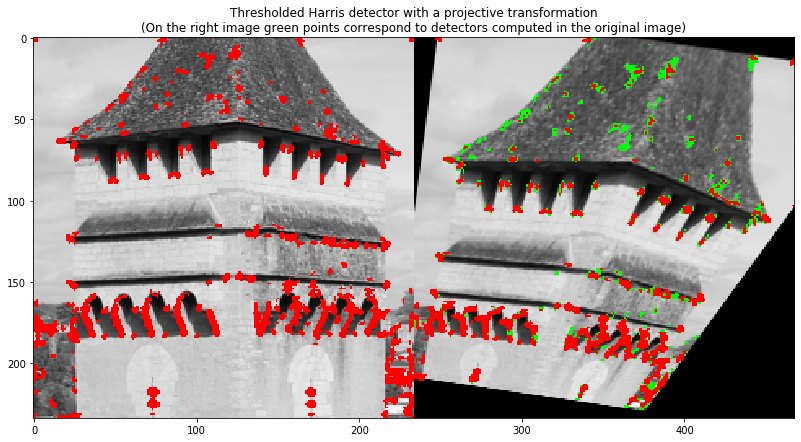

Proportion of matching points : 0.8606260296540362
Median point size : 13.0 Average point size 26.69090909090909


In [123]:
# Change of view point
t = 0.01

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = threshold(val_h,t)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = threshold(imgb_h,t)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Thresholded Harris detector with a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())
print("Median point size :", median_pt_size(thld_a)[0], "Average point size", avrge_pt_size(thld_a)[0])

### Quantitative results ###

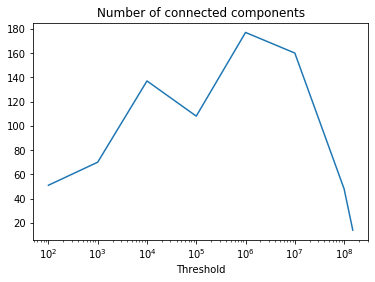

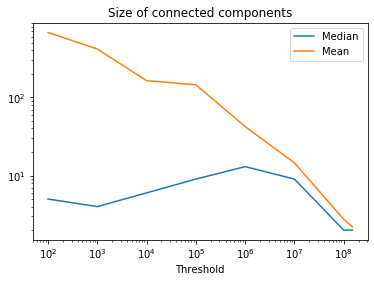

In [125]:
# Impact of the threshold
ts = [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1.5e8]
results_sum = []
results_avg = []
results_med = []

corners = corner_harris(img)

for t in ts:
    pts = threshold(corners, t, fixed=True)
    avg, num = avrge_pt_size(pts)
    med, _ = median_pt_size(pts)
    results_sum.append(num)
    results_med.append(med)
    results_avg.append(avg)

plt.title('Number of connected components')
plt.xlabel('Threshold')
plt.semilogx(ts, results_sum)
plt.show()

plt.title('Size of connected components')
plt.xlabel('Threshold')
plt.loglog(ts, results_med, label='Median')
plt.loglog(ts, results_avg, label='Mean')
plt.legend()
plt.show()

In [30]:
cat = ("Thresholded", "NMS", "ANMS")

results_scale = []
results_rotation = []
results_noise = []

results_scale_squares = []
results_rotation_squares = []
results_noise_squares = []

In [28]:
def img2list(img):
    w = np.where(img)
    return np.vstack(w).T

def matching(correlA, correlB, r=1.5):
    if correlA.dtype == float:
        correlA = correlA > 0.5 * correlA.max()
    if correlB.dtype == float:
        correlB = correlB > 0.5 * correlB.max()
    
    posA = img2list(correlA)
    posB = img2list(correlB)
    
    dist = cdist(posA, posB, metric='sqeuclidean')
    
    mindist = dist.min(axis=1)
    
    return np.sum(mindist < r*r)

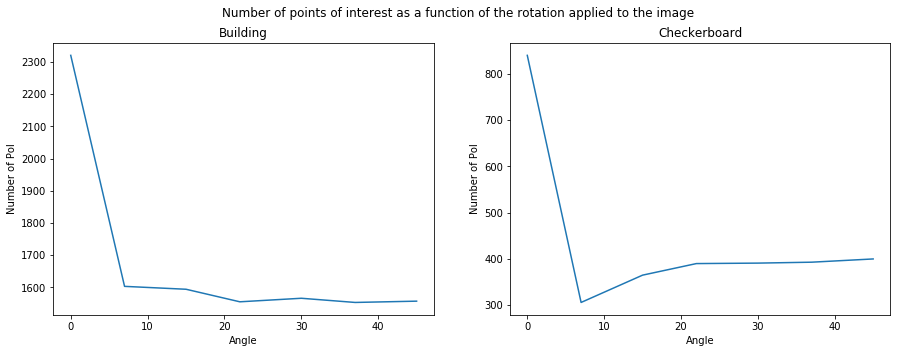

In [20]:
angles = [0,7,15,22,30,37,45]
results = []

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners,1e7,fixed=True)
    results.append(harris.sum())
 
 

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners,10,fixed=True)
    sresults.append(harris.sum())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

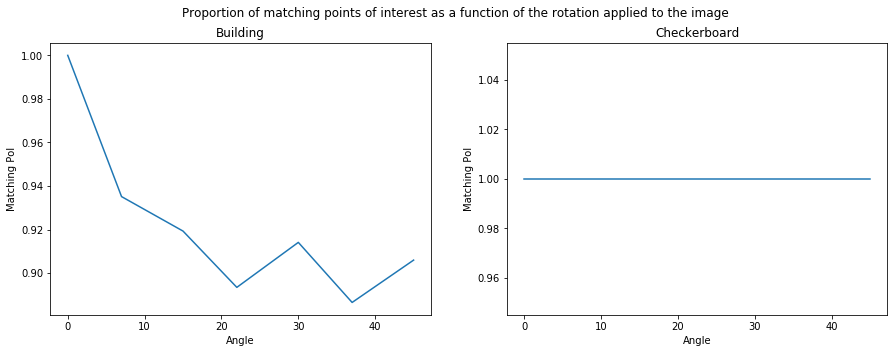

In [31]:
angles = [0,7,15,22,30,37,45]

results = []

corners = corner_harris(img)
harris0 = threshold(corners, 0.01).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners, 0.01)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

    
sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, 0.01).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = threshold(corners, 0.01)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


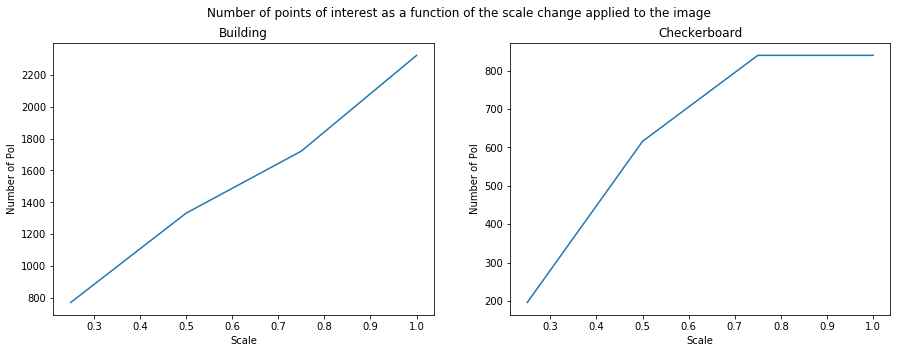

In [32]:
scales = [0.25,0.5,0.75,1]

results = []
for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners,1e7,fixed=True)
    results.append(harris.sum())
 
 

sresults = []
for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners,1e1,fixed=True)
    sresults.append(harris.sum())
 
 
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Scale")

plt.show()

The number of detected points varies with the scale of the image.

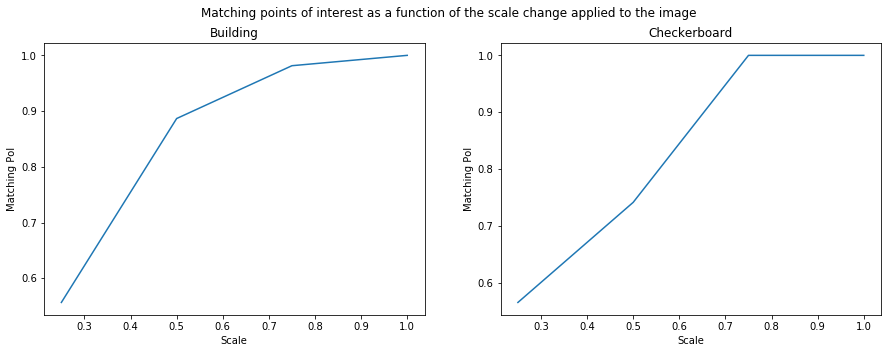

In [33]:
scales = [0.25,0.5,0.75,1]

results = []
t = 0.01

corners = corner_harris(img)
harris0 = threshold(corners, t).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, t).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = threshold(corners, t)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

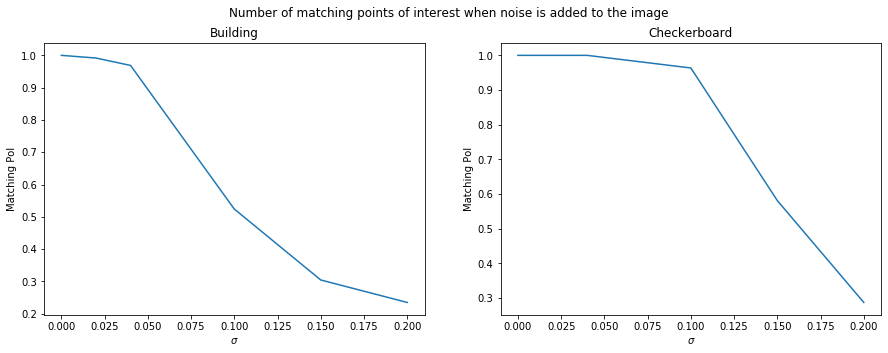

In [34]:
sigmas = [0,0.02,0.04,0.1,0.15,0.2]

results = []

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = threshold(corners, t)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = threshold(corners, t)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = threshold(corners, t)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = threshold(corners, t)
    sresults.append(matching(harris, harris0)/harris.sum())

results_noise.append(results)
results_noise_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

# NMS ##

In [35]:
def nms(pts, r=1, c=0.9):
    maxmap = np.zeros_like(pts,dtype=int)
    impad = np.zeros((pts.shape[0]+2*r, pts.shape[1]+2*r))
    impad[:,:] = np.NINF
    impad[r:-r,r:-r] = pts
    for (i,j) in np.ndindex(pts.shape):
        maxmap[i,j] = (c * (impad[i:i+2*r+1,j:j+2*r+1]).max() <= pts[i,j])
    return maxmap

def t_nms(pts, t=0.01, r=1, c=0.9 ,fixed=False):
    return nms(pts, r, c) * threshold(pts, t, fixed)


### Qualitative experiments ###

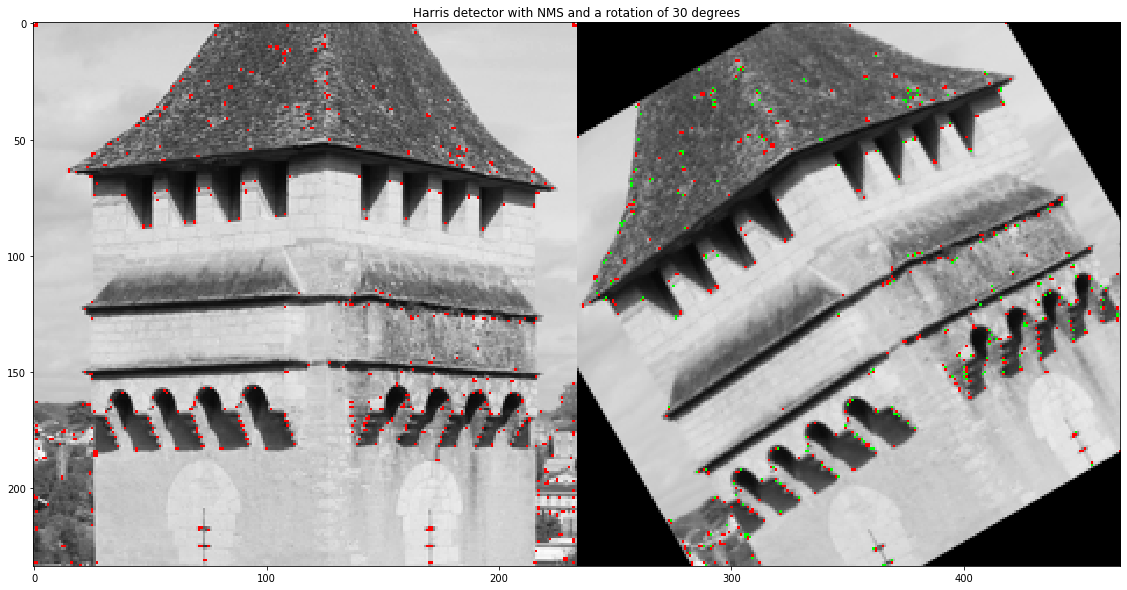

In [36]:
# Rotation
angle = 30
t = 0.01
r = 1
c = 0.9
fixed = False

imgb = rotate(img, angle)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(20,10))

plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),rotate(t_nms(val_h,t,r,c,fixed).astype(float),angle,order=0))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c,fixed),t_nms(imgb_h,t,r,c,fixed)))))
plt.title("Harris detector with NMS and a rotation of {} degrees".format(angle))
plt.show()

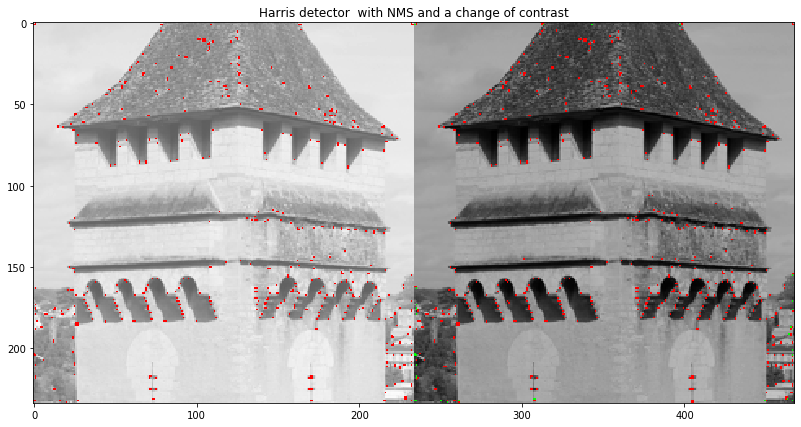

In [37]:
# Contrast change
t = 0.01
r = 1
c = 0.9
fixed = False

imgb = (img - img.mean()) * 1.25 + 20
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),t_nms(val_h,t,r,c,fixed))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c,fixed),t_nms(imgb_h,t,r,c,fixed)))))
plt.title("Harris detector  with NMS and a change of contrast")
plt.show()


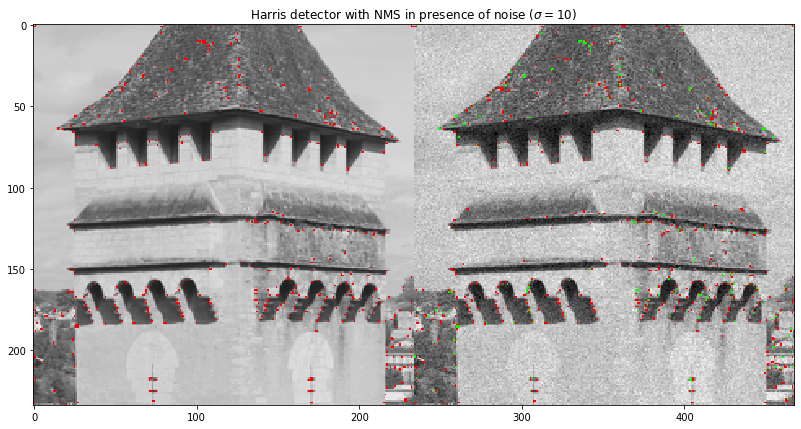

In [38]:
# Noise
sigma = 10

t = 0.01
r = 1
c = 0.9
fixed = False

imgb = img + 5 * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')


plt.imshow(point_map(np.hstack((np.zeros_like(img),t_nms(val_h,t,r,c,fixed))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((t_nms(val_h,t,r,c,fixed),t_nms(imgb_h,t,r,c,fixed)))))
plt.title("Harris detector with NMS in presence of noise ($\sigma ={}$)".format(sigma))
plt.show()


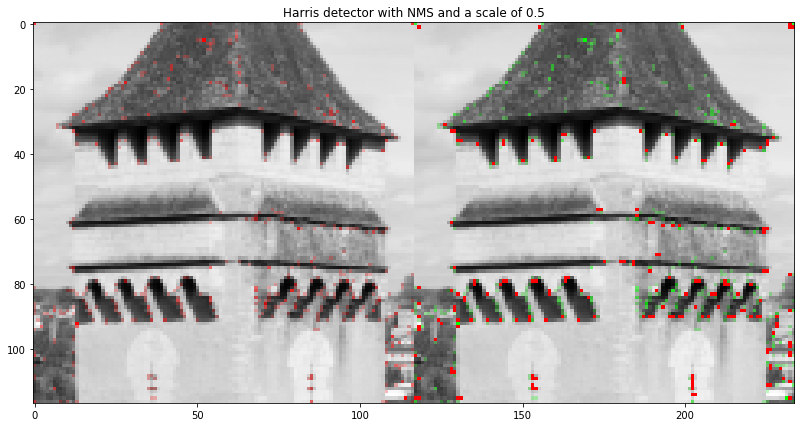

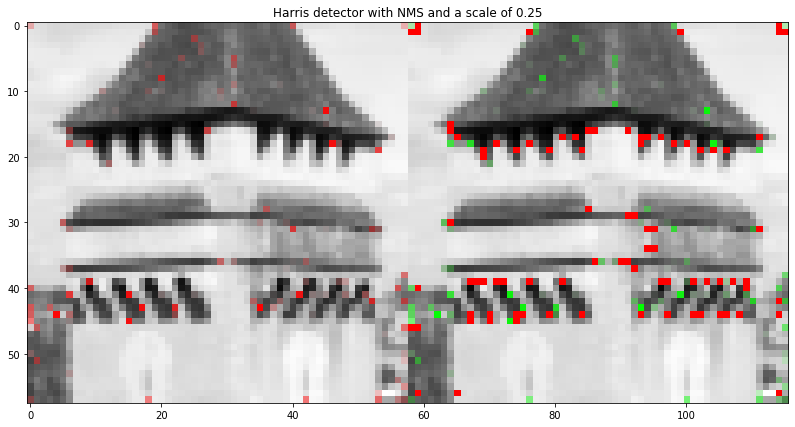

In [39]:
# Scale change
scale = [0.5,0.25]

t = 0.01
r = 1
c = 0.9
fixed = False

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(t_nms(val_h,t,r,c,fixed).astype(float), imgb.shape, anti_aliasing=False)
    
    img_s = resize(img, imgb.shape)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((img_s,imgb)),cmap='gray')

    plt.imshow(point_map(np.hstack((np.zeros_like(imgb),scaled_a)),color=(0,1,0)))
    plt.imshow(point_map(np.hstack((scaled_a,t_nms(imgb_h,t,r,c,fixed)))))
    
    plt.title("Harris detector with NMS and a scale of {}".format(s))
    
    plt.show()


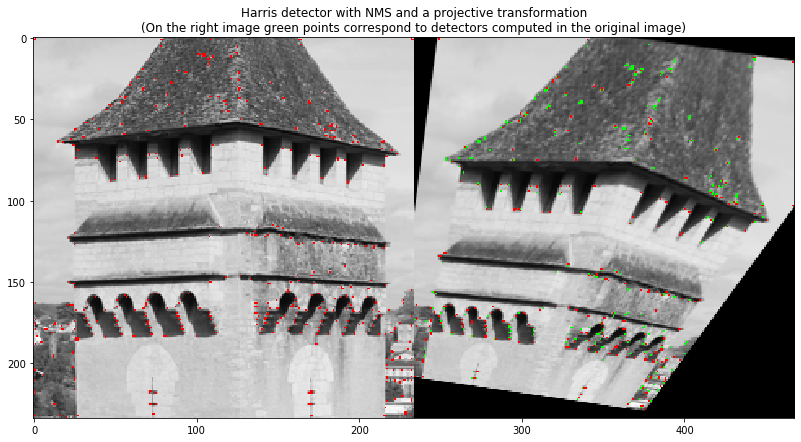

Proportion of matching points : 0.6321585903083701


In [73]:
# Change of view point
t = 0.01
r = 1
c = 0.9
fixed = False

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = t_nms(val_h,t,r,c,fixed)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = t_nms(imgb_h,t,r,c,fixed)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Harris detector with NMS and a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())

### Quantitative results ###

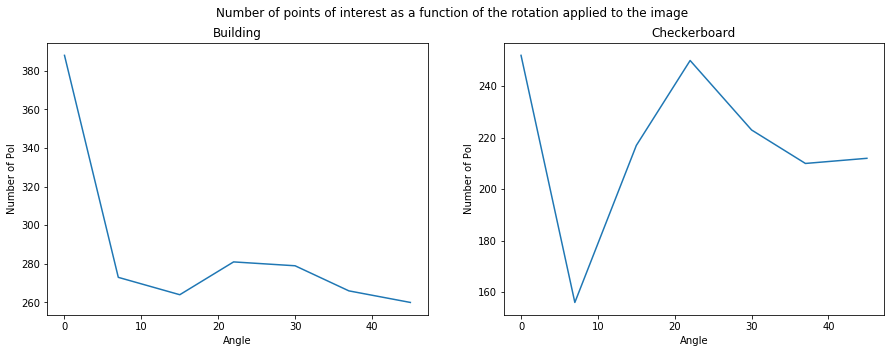

In [42]:
angles = [0,7,15,22,30,37,45]
results = []

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,1e7,fixed=True)
    results.append(harris.sum())
 
 

sresults = []

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,10,fixed=True)
    sresults.append(harris.sum())
 
 
 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Angle")

plt.show()

Once again the number of detected points changes with the orientation of the image.

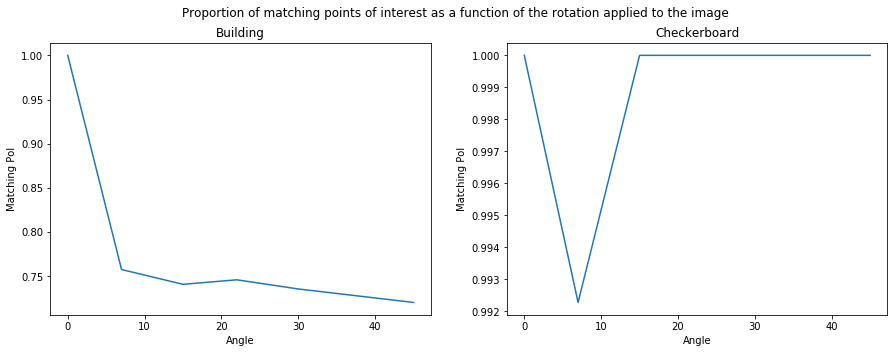

In [43]:
angles = [0,7,15,22,30,37,45]
results = []

corners = corner_harris(img)
harris0 = t_nms(corners, t=0.01, r=1, c=0.9).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners, t=0.01, r=1, c=0.9)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners, t=0.01, r=1, c=0.9).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = t_nms(corners, t=0.01, r=1, c=0.9)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


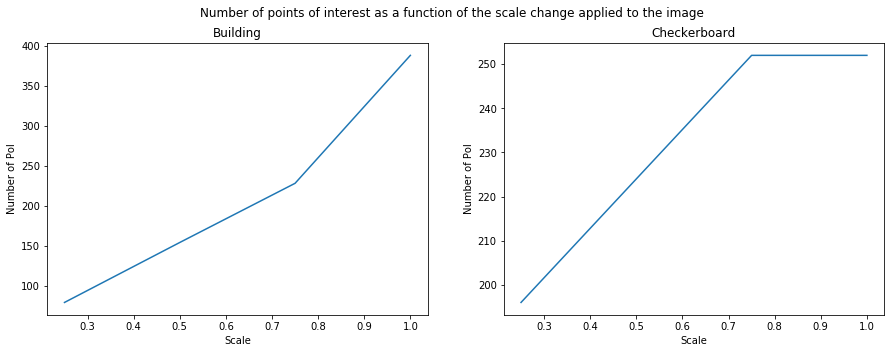

In [44]:
scales = [0.25,0.5,0.75,1]

results = []
for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,1e7,fixed=True)
    results.append(harris.sum())
 
 

sresults = []
for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners,1e1,fixed=True)
    sresults.append(harris.sum())
 
 
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Number of PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Number of PoI", xlabel = "Scale")

plt.show()

The number of detected points varies with the scale of the image.

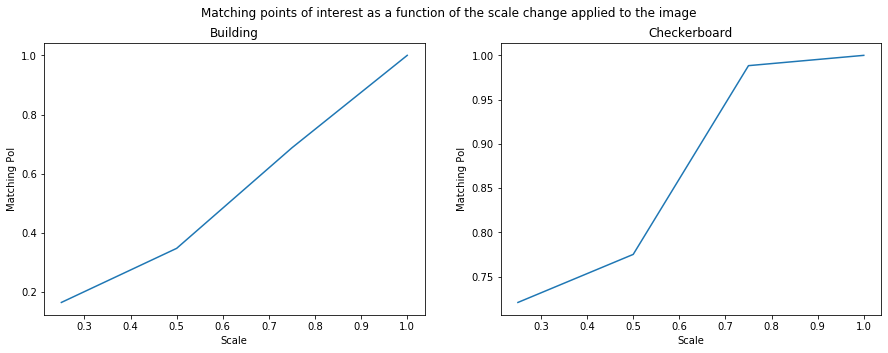

In [45]:
scales = [0.25,0.5,0.75,1]

results = []

corners = corner_harris(img)
harris0 = t_nms(corners).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = t_nms(corners)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

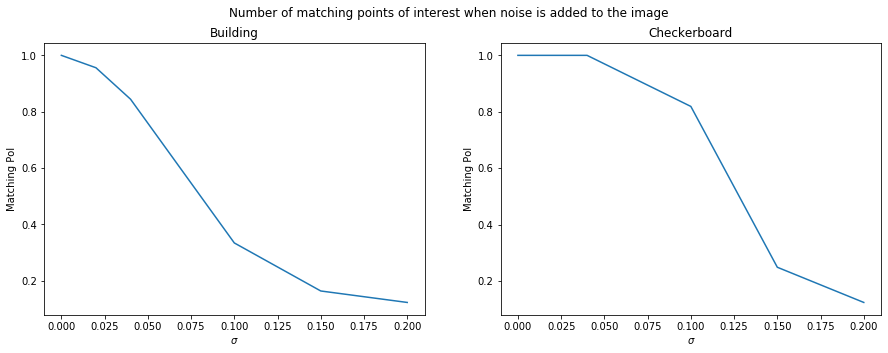

In [46]:
sigmas = [0,0.02,0.04,0.1,0.15,0.2]

results = []

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = t_nms(corners).astype(float)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = t_nms(corners)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = t_nms(corners).astype(float)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = t_nms(corners)
    sresults.append(matching(harris, harris0)/harris.sum())
 
   
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

## ANMS ##

In [47]:
def anms(correl, n, t = 0.01, c=0.9, fixed = False):
    pts = threshold(correl, t, fixed=fixed)

    ic = 1/c
    width = pts.shape[1]
    
    detected = [(-correl[i,j],i,j) for i,j in np.ndindex(pts.shape) if pts[i,j]]
    detected.sort()
    detected = np.array(detected)
    
    detected_pos = np.array([[i,j] for _,i,j in detected])
    distances = squareform(pdist(detected_pos, metric='sqeuclidean'))
    npoints = np.arange(len(detected), dtype=int)
    
    rmap = np.zeros_like(correl)
    
    # Process the first point
    _,i,j = detected[0]
    rmap[int(i),int(j)] = - np.inf
    
    for k,(cor,i,j) in enumerate(detected[1:]):
        ccor = ic * cor
        k += 1
        
        bigger_processed = detected[:k,0] < ccor # We store -correl
        bigger_radius = distances[k,:k][bigger_processed]
        if len(bigger_radius) == 0:
            r = np.inf
        else:
            r = bigger_radius.min()
        rmap[int(i),int(j)] = -r
    
    # Extract the n best points
    pos = rmap.reshape(-1).argpartition(n)[:n]
    # Put the n best points in a 2D image
    res = np.zeros_like(pts)
    for p in pos:
        res[p // width, p % width] = True
    return res

### Qualitative experiments ###

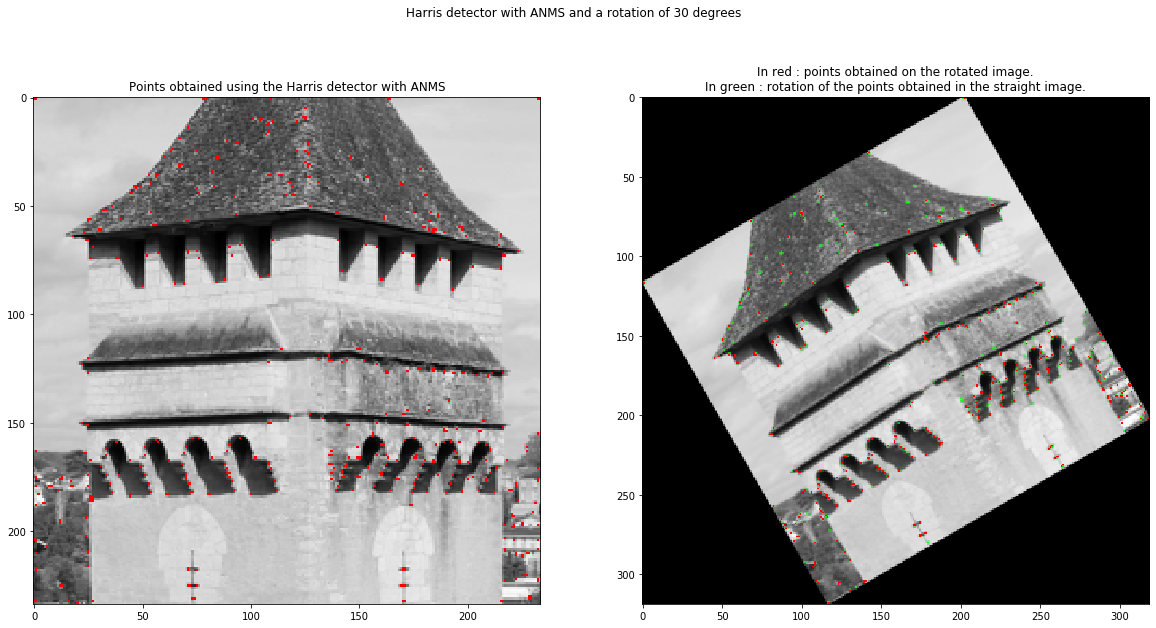

In [48]:
# Rotation
angle = 30
n = 500
t = 0.01
r = 1
c = 0.9
fixed = False

imgb = rotate(img, angle, resize=True)
imgb_h = corner_harris(imgb)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
fig.suptitle("Harris detector with ANMS and a rotation of {} degrees".format(angle))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(anms(val_h,n,t,c,fixed)))
ax1.set_title("Points obtained using the Harris detector with ANMS")

ax2.imshow(imgb,cmap="gray")
ax2.imshow(point_map(rotate(anms(val_h,n,t,c,fixed),angle,resize=True),color=(0,1,0)))
ax2.imshow(point_map(anms(imgb_h,n,t,c,fixed)))
ax2.set_title("In red : points obtained on the rotated image.\nIn green : rotation of the points obtained in the straight image.")
plt.show()

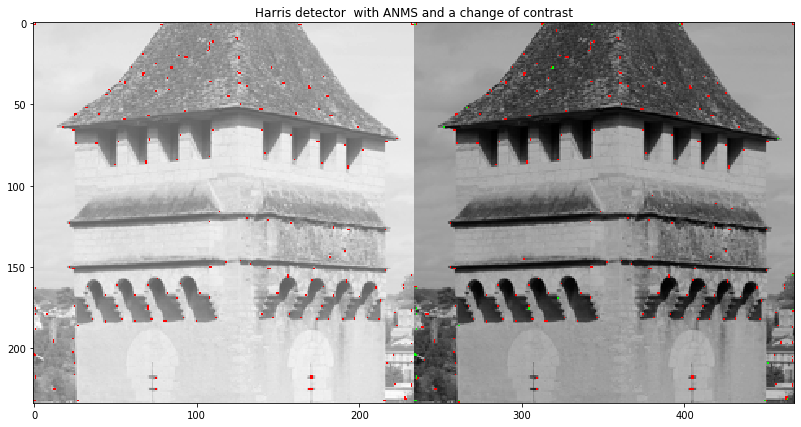

In [49]:
# Contrast change
n = 250
t = 0.01
r = 1
c = 0.9
fixed = False

imgb = (img - img.mean()) * 1.25 + 20
imgb_h = corner_harris(imgb)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(img),anms(val_h,n,t,c,fixed))),color=(0,1,0)))
plt.imshow(point_map(np.hstack((anms(val_h,n,t,c,fixed),anms(imgb_h,n,t,c,fixed)))))
plt.title("Harris detector  with ANMS and a change of contrast")
plt.show()

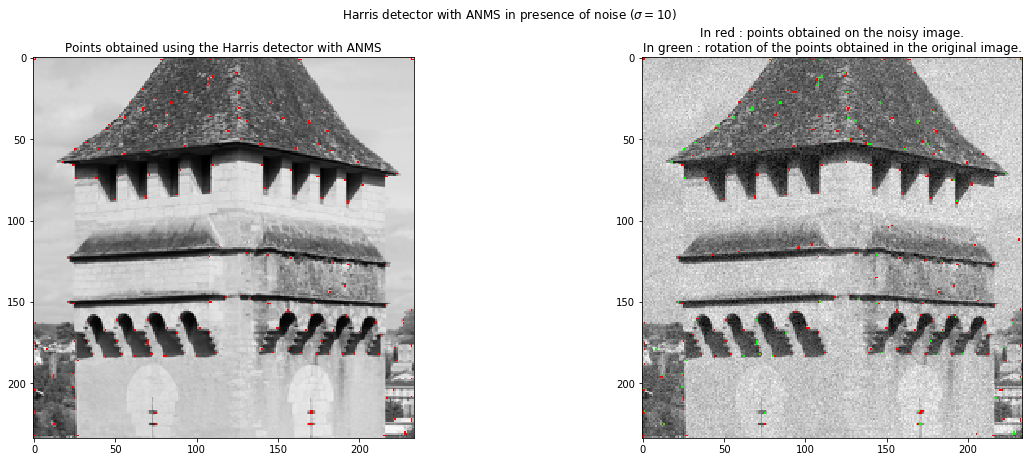

In [50]:
# Noise
sigma = 10

n = 250
t = 0.01
r = 1
c = 0.9
fixed = False

imgb = img + 5 * np.random.randn(*img.shape)
imgb_h = corner_harris(imgb)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
fig.suptitle("Harris detector with ANMS in presence of noise ($\sigma ={}$)".format(sigma))

ax1.imshow(img,cmap="gray")
ax1.imshow(point_map(anms(val_h,n,t,c,fixed)))
ax1.set_title("Points obtained using the Harris detector with ANMS")

ax2.imshow(imgb,cmap="gray")
ax2.imshow(point_map(anms(val_h,n,t,c,fixed),color=(0,1,0)))
ax2.imshow(point_map(anms(imgb_h,n,t,c,fixed)))
ax2.set_title("In red : points obtained on the noisy image.\nIn green : rotation of the points obtained in the original image.")
plt.show()


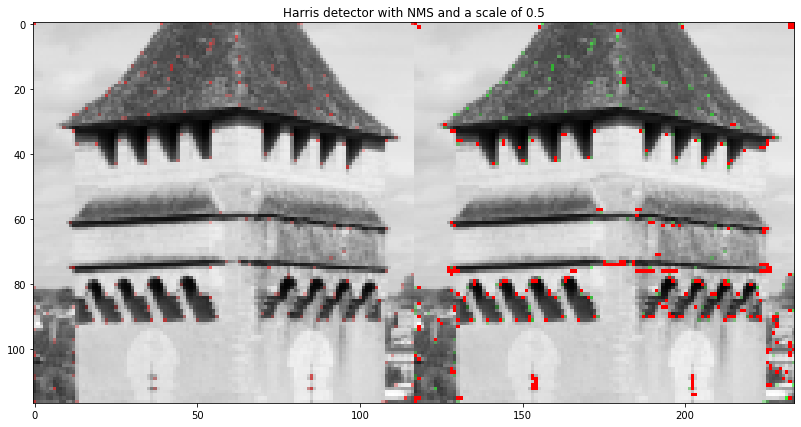

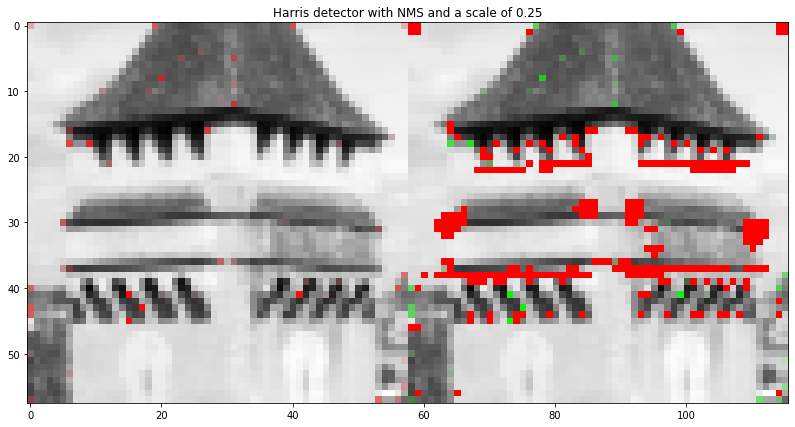

In [51]:
# Scale change
scale = [0.5,0.25]

n = 250
t = 0.01
r = 1
c = 0.9
fixed = False

for i,s in enumerate(scale):
    imgb = rescale(img, s)
    imgb_h = corner_harris(imgb)

    scaled_a = resize(anms(val_h,n,t,c,fixed).astype(float), imgb.shape, anti_aliasing=False)
    
    img_s = resize(img, imgb.shape)
    
    plt.figure(figsize=(15,7))
    plt.imshow(np.hstack((img_s,imgb)),cmap='gray')

    plt.imshow(point_map(np.hstack((np.zeros_like(imgb),scaled_a)),color=(0,1,0)))
    plt.imshow(point_map(np.hstack((scaled_a,anms(imgb_h,n,t,c,fixed)))))
    
    plt.title("Harris detector with NMS and a scale of {}".format(s))
    
    plt.show()


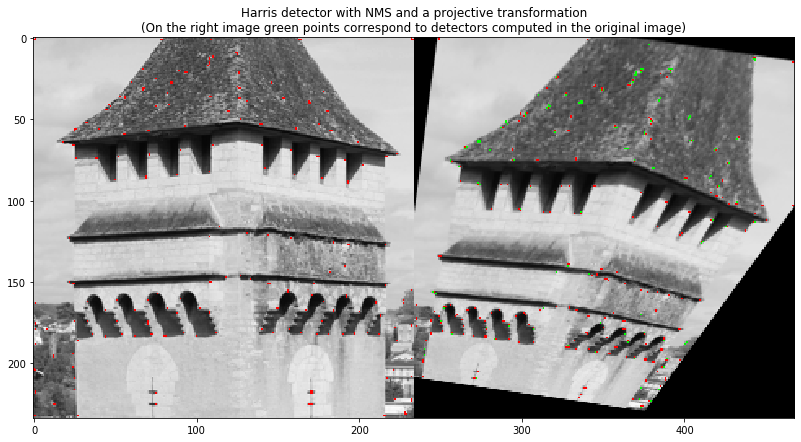

Proportion of matching points : 0.7703349282296651


In [72]:
# Change of view point
n = 250
t = 0.01 
r = 1
c = 0.9
fixed = False

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

imgb = warp(img,trsfm.inverse,preserve_range=False)
imgb_h = corner_harris(imgb)

thld_a = anms(val_h,n,t,c,fixed)
warped_ta = warp(thld_a.astype(float),trsfm.inverse,order=0)
thld_b = anms(imgb_h,n,t,c,fixed)

plt.figure(figsize=(15,7))
plt.imshow(np.hstack((img,imgb)),cmap='gray')

plt.imshow(point_map(np.hstack((np.zeros_like(thld_a),warped_ta)),color=(0,1,0)))
plt.imshow(point_map(np.hstack((thld_a,thld_b))))
plt.title("Harris detector with NMS and a projective transformation\n(On the right image green points correspond to detectors computed in the original image)")
plt.show()

print("Proportion of matching points :", matching(warped_ta,thld_b)/warped_ta.sum())

### Quantitative experiments ###

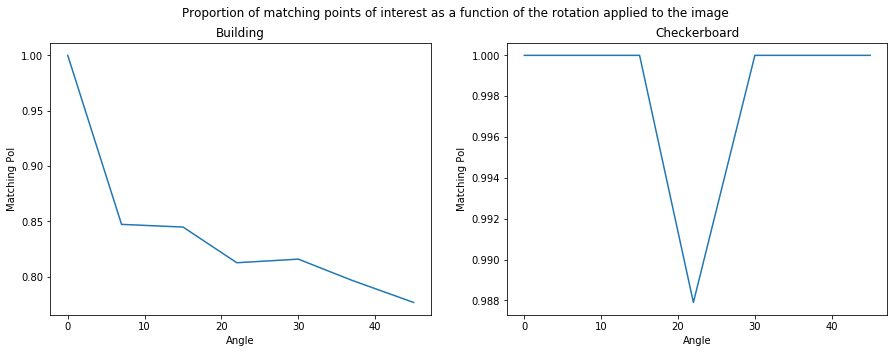

In [53]:
angles = [0,7,15,22,30,37,45]

n = 250
t = 0.01 
r = 1
c = 0.9

results = []

corners = corner_harris(img)
harris0 = anms(corners, n, t, c).astype(float)

for angle in angles:
    imgrot = rotate(img, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    results.append(matching(harris0_r, harris)/harris0_r.sum())

sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c).astype(float)

for angle in angles:
    imgrot = rotate(squares, angle,resize=True)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_r = rotate(harris0, angle, resize=True, order=0)
    sresults.append(matching(harris0_r, harris)/harris0_r.sum())

results_rotation.append(results)
results_rotation_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Proportion of matching points of interest as a function of the rotation applied to the image')
ax1.plot(angles, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

ax2.plot(angles, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()


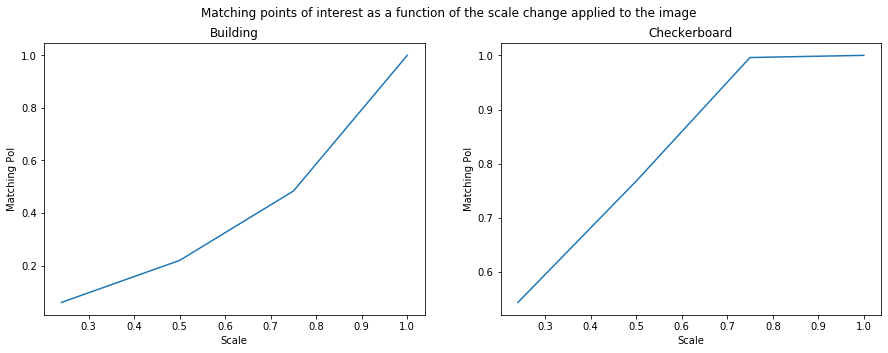

In [54]:
scales = [0.24,0.5,0.75,1]

n = 250
t = 0.01 
r = 1
c = 0.9

results = []

corners = corner_harris(img)
harris0 = anms(corners, n, t, c).astype(float)

for scale in scales:
    imgrot = rescale(img, scale)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_s = rescale(harris0, scale, order=0)
    results.append(matching(harris, harris0_s)/harris.sum())
    
sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c).astype(float)

for scale in scales:
    imgrot = rescale(squares, scale)
    corners = corner_harris(imgrot)
    harris = anms(corners, n, t, c)
    harris0_s = rescale(harris0, scale, order=0)
    sresults.append(matching(harris, harris0_s)/harris.sum())

results_scale.append(results)
results_scale_squares.append(sresults)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Matching points of interest as a function of the scale change applied to the image')
ax1.plot(scales, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

ax2.plot(scales, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

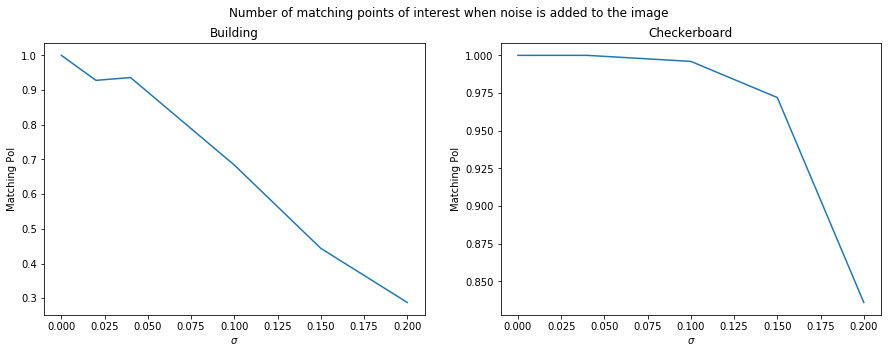

In [66]:
sigmas = [0,0.02,0.04,0.1,0.15,0.2]

n = 250
t = 0.1 
r = 1
c = 0.9

results = []

imgb = img / img.max()
corners = corner_harris(imgb)
harris0 = anms(corners, n, t, c)

for s in sigmas:
    imgn = imgb + s * np.random.randn(*imgb.shape)
    corners = corner_harris(imgn)
    harris = anms(corners, n, t, c)
    results.append(matching(harris, harris0)/harris.sum())

sresults = []

corners = corner_harris(squares)
harris0 = anms(corners, n, t, c)

for s in sigmas:
    imgn = squares + s * np.random.randn(*squares.shape)
    corners = corner_harris(imgn)
    harris = anms(corners, n, t, c)
    sresults.append(matching(harris, harris0)/harris.sum())

results_noise.append(results)
results_noise_squares.append(sresults)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of matching points of interest when noise is added to the image')
ax1.plot(sigmas, results)
ax1.set_title("Building")
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

ax2.plot(sigmas, sresults)
ax2.set_title("Checkerboard")
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()

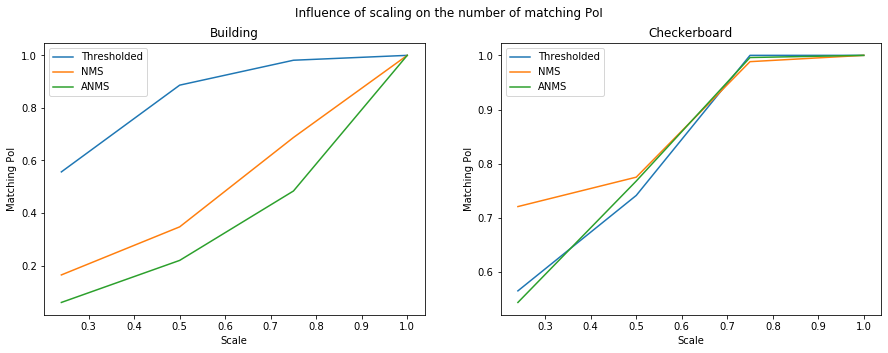

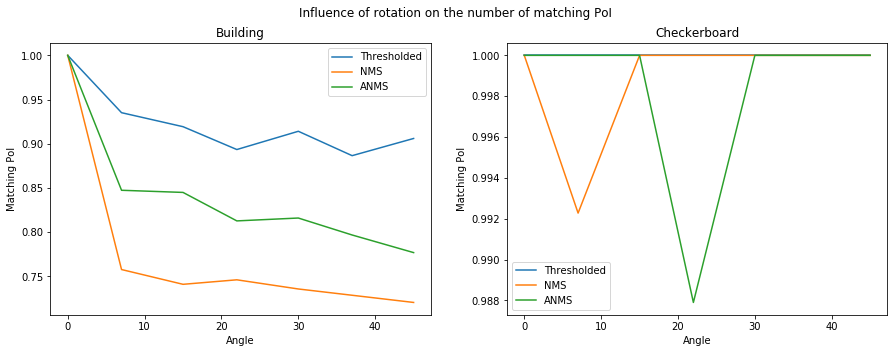

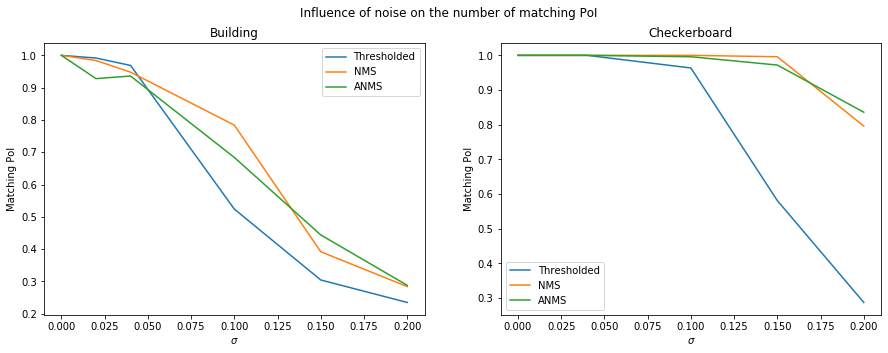

In [67]:
# Scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of scaling on the number of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(scales, results_scale[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "Scale")

for i, label in enumerate(cat):
    ax2.plot(scales, results_scale_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "Scale")

plt.show()

# Rotation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of rotation on the number of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(angles, results_rotation[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "Angle")

for i, label in enumerate(cat):
    ax2.plot(angles, results_rotation_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "Angle")

plt.show()

# Noise
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Influence of noise on the number of matching PoI')
for i, label in enumerate(cat):
    ax1.plot(sigmas, results_noise[i], label=label)
ax1.set_title("Building")
ax1.legend()
ax1.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

for i, label in enumerate(cat):
    ax2.plot(sigmas, results_noise_squares[i], label=label)
ax2.set_title("Checkerboard")
ax2.legend()
ax2.set(ylabel = "Matching PoI", xlabel = "$\sigma$")

plt.show()



In [134]:
# Change of view point
t = 0.01

theta = np.pi/12
trsfm = ProjectiveTransform(np.array([[ 0.8+np.cos(theta), -np.sin(theta), 25],
                                      [ np.sin(theta), 1.5+np.cos(theta), -25],
                                      [ 0, 0.005, 1.5]]))

thld_a = threshold(val_h,t)
nms_a = t_nms(val_h, t)
anms_a = anms(val_h, 250, t)

print("Threshold :")
print("  Number of connected components :", median_pt_size(thld_a)[1])
print("  Median point size : {} ".format(int(median_pt_size(thld_a)[0])))
print("  Average point size : {:.2f}".format(avrge_pt_size(thld_a)[0]))

print("NMS :")
print("  Number of connected components :", median_pt_size(nms_a)[1])
print("  Median point size : {} ".format(int(median_pt_size(nms_a)[0])))
print("  Average point size : {:.2f}".format(avrge_pt_size(nms_a)[0]))

print("ANMS :")
print("  Number of connected components :", median_pt_size(anms_a)[1])
print("  Median point size : {} ".format(int(median_pt_size(anms_a)[0])))
print("  Average point size : {:.2f}".format(avrge_pt_size(anms_a)[0]))

Threshold :
  Number of connected components : 165
  Median point size : 13 
  Average point size : 26.69
NMS :
  Number of connected components : 378
  Median point size : 1 
  Average point size : 1.52
ANMS :
  Number of connected components : 168
  Median point size : 1 
  Average point size : 1.49
